In [213]:
%matplotlib inline
import warnings
import dill
# dill.load_session('msm_whole_trajectories.db')
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import mdtraj as md
import matplotlib



In [214]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt


## Load and inspect the data

In [215]:
traj = md.load('data/traj_3.xtc',top= 'data/water_top.pdb')
dt = traj.timestep
traj = md.compute_center_of_mass(traj)
traj.shape

(10000001, 3)

In [216]:
# df = pd.DataFrame(com, columns=['1', '2', '3'])
# df['t'] = traj.time/1000

# df_melt = pd.melt(frame=df, id_vars=['t'], value_vars=['1', '2', '3'], var_name='coord', )

# df_melt.head()

In [217]:
# g = sns.FacetGrid(df_melt.iloc[::100,:], col='coord')
# g.map(plt.scatter, 't', 'value', alpha=0.5, s=1)
# g.set_axis_labels('time (ns)', 'position (nm)')

Text(0.5, 0, 'z')

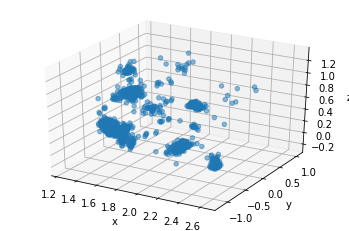

In [218]:
stride=5000
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
ax.scatter(xs=traj[::stride,0], ys=traj[::stride,1], zs=traj[::stride,2], alpha=0.5)
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.set_zlabel('z')

## Split data into 1ns pieces

This is because we have a wide variety of behaviour across the trajectory and we only want to focus on small chunks at a time. 

In [219]:
window = 1000 # window size in ps
n_frames = int(window/dt) # number of frames in a window
n_splits = traj.shape[0]//n_frames # number of windows in trajectory
traj_split = np.array_split(traj, n_splits) # the split up 

## Set MSM parameters


In [220]:
msm_lag = int(10/dt)
tica_lag = int(5/dt)
n_clusters = int(np.sqrt(n_frames))

## Fit models

In [221]:
# # Fit tica and get tica trajs
# tica_objs = [coor.tica(traj, lag=tica_lag, dim=3,  kinetic_map=True) for traj in traj_split]
# tica_trajs = [x.get_output() for x in tica_objs]

# Cluster using kmeans
dtraj_objs = [coor.cluster_kmeans(traj, k=n_clusters, max_iter=100) for traj in traj_split[:100]]


In [222]:
# Extract dtrajs
dtrajs = [x.dtrajs for x in dtraj_objs]

# get implied timescale plots
msms = [msm.estimate_markov_model(dtraj, lag=msm_lag) for dtraj in dtrajs]

Find the largest gap in the timescales first - some of these might give sink states though. 

In [223]:
ts_ratios = []
for mm in msms:
    ts = mm.timescales()[:5]
    ts_ratio = ts[:-1]/ts[1:]
    max_ratio = np.max(ts_ratio)
    n_states = np.argmax(ts_ratio)+2
    t2 = ts[0]
    ts_ratios.append((mm, n_states, max_ratio, t2))

Now fit the Hidden Markov Models. 

In [224]:
hmms = [(i, mm.coarse_grain(n)) for i, (mm, n, ratio, t) in enumerate(ts_ratios) 
        if (ratio > 1.5) & (t > mm.lag)]


In [225]:
# If one of the lifetimes is infinity, that means there's an absorbing state so there's no oscilation
non_absorbing = [(i, hmm) for (i, hmm) in hmms if not np.any(np.abs(hmm.lifetimes)==np.inf)]

In [226]:
hmm_dict = dict(non_absorbing)


## Plot results

In [247]:
# This file is part of PyEMMA.
#
# Copyright (c) 2014-2016 Computational Molecular Biology Group, Freie Universitaet Berlin (GER)
#
# PyEMMA is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU Lesser General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.


import numpy as _np
import warnings
from pyemma.util import types as _types

from math import sqrt as _sqrt
import logging

logger = logging.getLogger(__name__)


__author__ = 'noe, marscher'
__all__ = ['plot_flux', 'plot_network', 'plot_markov_model', 'NetworkPlot']


class NetworkPlot(object):
    r"""Plot of network with nodes and arcs """

    def __init__(self, A, pos=None, xpos=None, ypos=None, ax=None):
        r"""
        Parameters
        ----------
        A : ndarray(n,n)
            weight matrix or adjacency matrix of the network to visualize
        pos : ndarray(n,2)
            user-defined positions
        xpos : ndarray(n,)
            user-defined x-positions
        ypos : ndarray(n,)
            user-defined y-positions
        ax : matplotlib Axes object, optional, default=None
            The axes to plot to. When set to None a new Axes (and Figure) object will be used.
        Examples
        --------
        We define first define a reactive flux by taking the following transition
        matrix and computing TPT from state 2 to 3.
        >>> import numpy as np
        >>> P = np.array([[0.8,  0.15, 0.05,  0.0,  0.0],
        ...               [0.1,  0.75, 0.05, 0.05, 0.05],
        ...               [0.05,  0.1,  0.8,  0.0,  0.05],
        ...               [0.0,  0.2, 0.0,  0.8,  0.0],
        ...               [0.0,  0.02, 0.02, 0.0,  0.96]])
        >>> from pyemma import msm
        >>> F = msm.tpt(msm.markov_model(P), [2], [3])
        now plot the gross flux
        >>> NetworkPlot(F.gross_flux).plot_network() # doctest: +ELLIPSIS
        <...Figure...
        """

        if A.shape[0] >= 50:
            warnings.warn("The layout optimization method will take a long"
                          " time for large networks! It is recommended to"
                          " coarse grain your model first!")
        self.A = A
        if pos is not None and len(pos) < len(A):
            raise ValueError(
                'Given less positions (%i) than states (%i)' % (len(pos), len(A)))
        if xpos is not None and len(xpos) < len(A):
            raise ValueError(
                'Given less positions (%i) than states (%i)' % (len(xpos), len(A)))
        if ypos is not None and len(ypos) < len(A):
            raise ValueError(
                'Given less positions (%i) than states (%i)' % (len(ypos), len(A)))
        self.pos = pos
        self.xpos = xpos
        self.ypos = ypos
        self.ax = ax

    def _draw_arrow(
        self, x1, y1, x2, y2, Dx, Dy, label="", width=1.0, arrow_curvature=1.0, color="grey",
        patchA=None, patchB=None, shrinkA=0, shrinkB=0, arrow_label_size=None):
        """
        Draws a slightly curved arrow from (x1,y1) to (x2,y2).
        Will allow the given patches at start end end.
        """
        # set arrow properties
        dist = _sqrt(
            ((x2 - x1) / float(Dx))**2 + ((y2 - y1) / float(Dy))**2)
        arrow_curvature *= 0.075  # standard scale
        rad = arrow_curvature / (dist)
        tail_width = width
        head_width = max(0.5, 2 * width)
        head_length = head_width
        self.ax.annotate(
            "", xy=(x2, y2), xycoords='data', xytext=(x1, y1), textcoords='data',
            arrowprops=dict(
                arrowstyle='simple,head_length=%f,head_width=%f,tail_width=%f' % (
                    head_length, head_width, tail_width),
                color=color, shrinkA=shrinkA, shrinkB=shrinkB, patchA=patchA, patchB=patchB,
                connectionstyle="arc3,rad=%f" % -rad),
            zorder=0)
        # weighted center position
        center = _np.array([0.55 * x1 + 0.45 * x2, 0.55 * y1 + 0.45 * y2])
        v = _np.array([x2 - x1, y2 - y1])  # 1->2 vector
        vabs = _np.abs(v)
        vnorm = _np.array([v[1], -v[0]])  # orthogonal vector
        vnorm = _np.divide(vnorm, _np.linalg.norm(vnorm))  # normalize
        # cross product to determine the direction into which vnorm points
        z = _np.cross(v, vnorm)
        if z < 0:
            vnorm *= -1
        offset = 0.5 * arrow_curvature * \
            ((vabs[0] / (vabs[0] + vabs[1]))
             * Dx + (vabs[1] / (vabs[0] + vabs[1])) * Dy)
        ptext = center + offset * vnorm
        self.ax.text(
            ptext[0], ptext[1], label, size=arrow_label_size,
            horizontalalignment='center', verticalalignment='center', zorder=1, 
            bbox=dict(facecolor='w', alpha=0.75, edgecolor='w'))

    def plot_network(
        self, state_sizes=None, state_scale=1.0, state_colors='#ff5500', state_labels='auto',
        arrow_scale=1.0, arrow_curvature=1.0, arrow_labels='weights', arrow_label_format='%10.2f',
        max_width=12, max_height=12, figpadding=0.2, xticks=False, yticks=False, show_frame=False,
        **textkwargs):
        """
        Draws a network using discs and curved arrows.
        The thicknesses and labels of the arrows are taken from the off-diagonal matrix elements
        in A.
        """

        # Set the default values for the text dictionary
        from matplotlib import pyplot as _plt
        textkwargs.setdefault('size', None)
        textkwargs.setdefault('horizontalalignment', 'center')
        textkwargs.setdefault('verticalalignment', 'center')
        textkwargs.setdefault('color', 'black')
        # remove the temporary key 'arrow_label_size' as it cannot be parsed by plt.text!
        arrow_label_size = textkwargs.pop('arrow_label_size', textkwargs['size'])
        if self.pos is None:
            self.layout_automatic()
        # number of nodes
        n = len(self.pos)
        # get bounds and pad figure
        xmin = _np.min(self.pos[:, 0])
        xmax = _np.max(self.pos[:, 0])
        Dx = xmax - xmin
        xmin -= Dx * figpadding
        xmax += Dx * figpadding
        Dx *= 1 + figpadding
        ymin = _np.min(self.pos[:, 1])
        ymax = _np.max(self.pos[:, 1])
        Dy = ymax - ymin
        ymin -= Dy * figpadding
        ymax += Dy * figpadding
        Dy *= 1 + figpadding
        # sizes of nodes
        if state_sizes is None:
            state_sizes = 0.5 * state_scale * \
                min(Dx, Dy)**2 * _np.ones(n) / float(n)
        else:
            state_sizes = 0.5 * state_scale * \
                min(Dx, Dy)**2 * state_sizes / (_np.max(state_sizes) * float(n))
        # automatic arrow rescaling
        arrow_scale *= 1.0 / \
            (_np.max(self.A - _np.diag(_np.diag(self.A))) * _sqrt(n))
        # size figure
        if (Dx / max_width > Dy / max_height):
            figsize = (max_width, Dy * (max_width / Dx))
        else:
            figsize = (Dx / Dy * max_height, max_height)
        if self.ax is None:
            logger.debug("creating new figure")
            fig = _plt.figure(None, figsize=figsize)
            self.ax = fig.add_subplot(111)
        else:
            fig = self.ax.figure
            window_extend = self.ax.get_window_extent()
            axes_ratio = window_extend.height / window_extend.width
            data_ratio = (ymax - ymin) / (xmax - xmin)
            q = axes_ratio / data_ratio
            if q > 1.0:
                ymin *= q
                ymax *= q
            else:
                xmin /= q
                xmax /= q
        if not xticks:
            self.ax.get_xaxis().set_ticks([])
        if not yticks:
            self.ax.get_yaxis().set_ticks([])
        # show or suppress frame
        self.ax.set_frame_on(show_frame)
        # set node labels
        if state_labels is None:
            pass
        elif isinstance(state_labels, str) and state_labels == 'auto':
            state_labels = [str(i) for i in _np.arange(n)]
        else:
            if len(state_labels) != n:
                raise ValueError("length of state_labels({}) has to match length of states({})."
                                 .format(len(state_labels), n))
        # set node colors
        if state_colors is None:
            state_colors = '#ff5500'  # None is not acceptable
        if isinstance(state_colors, str):
            state_colors = [state_colors] * n
        if isinstance(state_colors, list) and not len(state_colors) == n:
            raise ValueError("Mistmatch between nstates and nr. state_colors (%u vs %u)" % (n, len(state_colors)))
        try:
            colorscales = _types.ensure_ndarray(state_colors, ndim=1, kind='numeric')
            colorscales /= colorscales.max()
            state_colors = [_plt.cm.binary(int(256.0 * colorscales[i])) for i in range(n)]
        except AssertionError:
            # assume we have a list of strings now.
            logger.debug("could not cast 'state_colors' to numeric values.")

        # set arrow labels
        if isinstance(arrow_labels, _np.ndarray):
            L = arrow_labels
            if isinstance(arrow_labels[0,0], str):
                arrow_label_format = '%s'
        elif isinstance(arrow_labels, str) and arrow_labels.lower() == 'weights':
            L = self.A[:, :]
        elif arrow_labels is None:
            L = _np.empty(_np.shape(self.A), dtype=object)
            L[:, :] = ''
            arrow_label_format = '%s'
        else:
            raise ValueError('invalid arrow labels')

        # draw circles
        circles = []
        for i in range(n):
            # choose color
            c = _plt.Circle(
                self.pos[i], radius=_sqrt(
                    0.5 * state_sizes[i]) / 2.0,
                color=state_colors[i], zorder=2, linewidth=5, fill=False)
            circles.append(c)
            self.ax.add_artist(c)
            # add annotation
            if state_labels is not None:
                self.ax.text(self.pos[i][0], self.pos[i][1], state_labels[i], zorder=3, **textkwargs)

        assert len(circles) == n, "%i != %i" % (len(circles), n)

        # draw arrows
        for i in range(n):
            for j in range(i + 1, n):
                if (abs(self.A[i, j]) > 0):
                    self._draw_arrow(
                        self.pos[i, 0], self.pos[i, 1], self.pos[j, 0], self.pos[j, 1], Dx, Dy,
                        label=arrow_label_format%L[i, j], width=arrow_scale * self.A[i, j],
                        arrow_curvature=arrow_curvature, patchA=circles[i], patchB=circles[j],
                        shrinkA=3, shrinkB=0, arrow_label_size=arrow_label_size)
                if (abs(self.A[j, i]) > 0):
                    self._draw_arrow(
                        self.pos[j, 0], self.pos[j, 1], self.pos[i, 0], self.pos[i, 1], Dx, Dy,
                        label=arrow_label_format%L[j, i], width=arrow_scale * self.A[j, i],
                        arrow_curvature=arrow_curvature, patchA=circles[j], patchB=circles[i],
                        shrinkA=3, shrinkB=0, arrow_label_size=arrow_label_size)

        # plot
        self.ax.set_xlim(xmin, xmax)
        self.ax.set_ylim(ymin, ymax)
        return fig

    def _find_best_positions(self, G):
        """Finds best positions for the given graph (given as adjacency matrix)
        nodes by minimizing a network potential.
        """
        initpos = None
        holddim = None
        if self.xpos is not None:
            y = _np.random.random(len(self.xpos))
            initpos = _np.vstack((self.xpos, y)).T
            holddim = 0
        elif self.ypos is not None:
            x = _np.zeros_like(self.xpos)
            initpos = _np.vstack((x, self.ypos)).T
            holddim = 1
        # nothing to do
        elif self.xpos is not None and self.ypos is not None:
            return _np.array([self.xpos, self.ypos]), 0
        from pyemma.plots._ext.fruchterman_reingold import _fruchterman_reingold
        best_pos = _fruchterman_reingold(G, pos=initpos, dim=2, hold_dim=holddim)

        # rescale fixed to user settings and balance the other coordinate
        if self.xpos is not None:
            # rescale x to fixed value
            best_pos[:, 0] *= (_np.max(self.xpos) - _np.min(self.xpos)
                               ) / (_np.max(best_pos[:, 0]) - _np.min(best_pos[:, 0]))
            best_pos[:, 0] += _np.min(self.xpos) - _np.min(best_pos[:, 0])
            # rescale y to balance
            if _np.max(best_pos[:, 1]) - _np.min(best_pos[:, 1]) > 0.01:
                best_pos[:, 1] *= (_np.max(self.xpos) - _np.min(self.xpos)
                                   ) / (_np.max(best_pos[:, 1]) - _np.min(best_pos[:, 1]))
        if self.ypos is not None:
            best_pos[:, 1] *= (_np.max(self.ypos) - _np.min(self.ypos)
                               ) / (_np.max(best_pos[:, 1]) - _np.min(best_pos[:, 1]))
            best_pos[:, 1] += _np.min(self.ypos) - _np.min(best_pos[:, 1])
            # rescale x to balance
            if _np.max(best_pos[:, 0]) - _np.min(best_pos[:, 0]) > 0.01:
                best_pos[:, 0] *= (_np.max(self.ypos) - _np.min(self.ypos)
                                   ) / (_np.max(best_pos[:, 0]) - _np.min(best_pos[:, 0]))

        return best_pos

    def layout_automatic(self):
        n = len(self.A)
        I, J = _np.where(self.A > 0.0)
        # note: against intuition this has to be of type float
        A = _np.zeros((n, n))
        A[I, J] = 1

        self.pos = self._find_best_positions(A)


def plot_markov_model(
    P, pos=None, state_sizes=None, state_scale=1.0, state_colors='#ff5500', state_labels='auto',
    minflux=1e-6, arrow_scale=1.0, arrow_curvature=1.0, arrow_labels='weights',
    arrow_label_format='%2.e', max_width=12, max_height=12, figpadding=0.2, show_frame=False,
    ax=None, **textkwargs):
    r"""Network representation of MSM transition matrix
    This visualization is not optimized for large matrices. It is meant to be
    used for the visualization of small models with up to 10-20 states, e.g.
    obtained by a HMM coarse-graining. If used with large network, the automatic
    node positioning will be very slow and may still look ugly.
    Parameters
    ----------
    P : ndarray(n,n) or MSM object with attribute 'transition matrix'
        Transition matrix or MSM object
    pos : ndarray(n,2), optional, default=None
        User-defined positions to draw the states on. If not given, will try
        to place them automatically.
    state_sizes : ndarray(n), optional, default=None
        User-defined areas of the discs drawn for each state. If not given,
        the stationary probability of P will be used.
    state_colors : string, ndarray(n), or list, optional, default='#ff5500' (orange)
        string :
            a Hex code for a single color used for all states
        array :
            n values in [0,1] which will result in a grayscale plot
        list :
            of len = nstates, with a color for each state. The list can mix strings, RGB values and
            hex codes, e.g. :py:obj:`state_colors` = ['g', 'red', [.23, .34, .35], '#ff5500'] is
            possible.
    state_labels : list of strings, optional, default is 'auto'
        A list with a label for each state, to be displayed at the center
        of each node/state. If left to 'auto', the labels are automatically set to the state
        indices.
    minflux : float, optional, default=1e-6
        The minimal flux (p_i * p_ij) for a transition to be drawn
    arrow_scale : float, optional, default=1.0
        Relative arrow scale. Set to a value different from 1 to increase
        or decrease the arrow width.
    arrow_curvature : float, optional, default=1.0
        Relative arrow curvature. Set to a value different from 1 to make
        arrows more or less curved.
    arrow_labels : 'weights', None or a ndarray(n,n) with label strings. Optional, default='weights'
        Strings to be placed upon arrows. If None, no labels will be used.
        If 'weights', the elements of P will be used. If a matrix of strings is
        given by the user these will be used.
    arrow_label_format : str, optional, default='%10.2f'
        The numeric format to print the arrow labels
    max_width = 12
        The maximum figure width
    max_height = 12
        The maximum figure height
    figpadding = 0.2
        The relative figure size used for the padding
    show_frame: boolean (default=False)
        Draw a frame around the network.
    ax : matplotlib Axes object, optional, default=None
        The axes to plot to. When set to None a new Axes (and Figure) object will be used.
    textkwargs : optional argument for the text of the state and arrow labels.
        See http://matplotlib.org/api/text_api.html#matplotlib.text.Text for more info. The
        parameter 'size' refers to the size of the state and arrow labels and overwrites the
        matplotlib default. The parameter 'arrow_label_size' is only used for the arrow labels;
        please note that 'arrow_label_size' is not part of matplotlib.text.Text's set of parameters
        and will raise an exception when passed to matplotlib.text.Text directly.
    Returns
    -------
    fig, pos : matplotlib.Figure, ndarray(n,2)
    a Figure object containing the plot and the positions of states.
    Can be used later to plot a different network representation (e.g. the flux)
    Examples
    --------
    >>> import numpy as np
    >>> P = np.array([[0.8,  0.15, 0.05,  0.0,  0.0],
    ...              [0.1,  0.75, 0.05, 0.05, 0.05],
    ...              [0.05,  0.1,  0.8,  0.0,  0.05],
    ...              [0.0,  0.2, 0.0,  0.8,  0.0],
    ...              [0.0,  0.02, 0.02, 0.0,  0.96]])
    >>> plot_markov_model(P) # doctest:+ELLIPSIS
    (<...Figure..., array...)
    """
    from msmtools import analysis as msmana
    if isinstance(P, _np.ndarray):
        P = P.copy()
    else:
        # MSM object? then get transition matrix first
        P = P.transition_matrix.copy()
    if state_sizes is None:
        state_sizes = msmana.stationary_distribution(P)
    if minflux > 0:
        F = _np.dot(_np.diag(msmana.stationary_distribution(P)), P)
        I, J = _np.where(F < minflux)
        P[I, J] = 0.0
    plot = NetworkPlot(P, pos=pos, ax=ax)
    fig = plot.plot_network(
        state_sizes=state_sizes, state_scale=state_scale, state_colors=state_colors,
        state_labels=state_labels, arrow_scale=arrow_scale, arrow_curvature=arrow_curvature,
        arrow_labels=arrow_labels, arrow_label_format=arrow_label_format, max_width=max_width,
        max_height=max_height, figpadding=figpadding, xticks=False, yticks=False,
        show_frame=show_frame, **textkwargs)
    return fig, plot.pos


def plot_flux(
    flux, pos=None, state_sizes=None, flux_scale=1.0, state_scale=1.0, state_colors='#ff5500',
    state_labels='auto', minflux=1e-9, arrow_scale=1.0, arrow_curvature=1.0, arrow_labels='weights',
    arrow_label_format='%2.e', max_width=12, max_height=12, figpadding=0.2,
    attribute_to_plot='net_flux', show_frame=False, show_committor=True, ax=None, **textkwargs):
    r"""Network representation of reactive flux
    This visualization is not optimized for large fluxes. It is meant to be used
    for the visualization of small models with up to 10-20 states, e.g. obtained
    by a PCCA-based coarse-graining of the full flux. If used with large
    network, the automatic node positioning will be very slow and may still look
    ugly.
    Parameters
    ----------
    flux : :class:`ReactiveFlux <pyemma.msm.flux.ReactiveFlux>`
        reactive flux object
    pos : ndarray(n,2), optional, default=None
        User-defined positions to draw the states on. If not given, will set the
        x coordinates equal to the committor probability and try to place the y
        coordinates automatically
    state_sizes : ndarray(n), optional, default=None
        User-defined areas of the discs drawn for each state. If not given, the
        stationary probability of P will be used
    flux_scale : float, optional, default=1.0
        scaling of the flux values
    state_scale : float, optional, default=1.0
        scaling of the state circles
    state_colors : string, ndarray(n), or list, optional, default='#ff5500' (orange)
        string :
            a Hex code for a single color used for all states
        array :
            n values in [0,1] which will result in a grayscale plot
        list :
            of len = nstates, with a color for each state. The list can mix strings, RGB values and
            hex codes, e.g. :py:obj:`state_colors` = ['g', 'red', [.23, .34, .35], '#ff5500'] is
            possible.
    state_labels : list of strings, optional, default is 'auto'
        A list with a label for each state, to be displayed at the center
        of each node/state. If left to 'auto', the labels are automatically set to the state
        indices.
    minflux : float, optional, default=1e-9
        The minimal flux for a transition to be drawn
    arrow_scale : float, optional, default=1.0
        Relative arrow scale. Set to a value different from 1 to increase or
        decrease the arrow width.
    arrow_curvature : float, optional, default=1.0
        Relative arrow curvature. Set to a value different from 1 to make arrows
        more or less curved.
    arrow_labels : 'weights', None or a ndarray(n,n) with label strings. Optional, default='weights'
        Strings to be placed upon arrows. If None, no labels will be used. If
        'weights', the elements of P will be used. If a matrix of strings is
        given by the user these will be used.
    arrow_label_format : str, optional, default='%10.2f'
        The numeric format to print the arrow labels
    max_width : int (default = 12)
        The maximum figure width
    max_height: int (default = 12)
        The maximum figure height
    figpadding: float (default = 0.2)
        The relative figure size used for the padding
    attribute_to_plot : str, optional, default='net_flux'
        specify the attribute of the flux object to plot.
    show_frame: boolean (default=False)
        Draw a frame around the network.
    show_committor: boolean (default=False)
        Print the committor value on the x-axis.
    ax : matplotlib Axes object, optional, default=None
        The axes to plot to. When set to None a new Axes (and Figure) object will be used.
    textkwargs : optional argument for the text of the state and arrow labels.
        See http://matplotlib.org/api/text_api.html#matplotlib.text.Text for more info. The
        parameter 'size' refers to the size of the state and arrow labels and overwrites the
        matplotlib default. The parameter 'arrow_label_size' is only used for the arrow labels;
        please note that 'arrow_label_size' is not part of matplotlib.text.Text's set of parameters
        and will raise an exception when passed to matplotlib.text.Text directly.
    Returns
    -------
    (fig, pos) : matpotlib.Figure instance, ndarray
        Axes instances containing the plot. Use pyplot.show() to display it.
        The positions of states. Can be used later to plot a different network
        representation (e.g. the flux).
    Examples
    --------
    We define first define a reactive flux by taking the following transition
    matrix and computing TPT from state 2 to 3
    >>> import numpy as np
    >>> P = np.array([[0.8,  0.15, 0.05,  0.0,  0.0],
    ...               [0.1,  0.75, 0.05, 0.05, 0.05],
    ...               [0.05,  0.1,  0.8,  0.0,  0.05],
    ...               [0.0,  0.2, 0.0,  0.8,  0.0],
    ...               [0.0,  0.02, 0.02, 0.0,  0.96]])
    >>> from pyemma import msm
    >>> F = msm.tpt(msm.markov_model(P), [2], [3])
    >>> F.flux[:] *= 100
    Scale the flux by 100 is basically a change of units to get numbers close
    to 1 (avoid printing many zeros). Now we visualize the flux:
    >>> plot_flux(F) # doctest:+ELLIPSIS
    (<...Figure..., array...)
    """
    from matplotlib import pylab as plt
    F = flux_scale * getattr(flux, attribute_to_plot)
    c = flux.committor
    if state_sizes is None:
        state_sizes = flux.stationary_distribution
    plot = NetworkPlot(F, pos=pos, xpos=c, ax=ax)
    if minflux > 0:
        I, J = _np.where(F < minflux)
        F[I, J] = 0.0

    if isinstance(state_labels, str) and state_labels == 'auto':
        # the first and last element correspond to A and B in ReactiveFlux
        state_labels = _np.array([str(i) for i in range(flux.nstates)])
        state_labels[_np.array(flux.A)] = "A"
        state_labels[_np.array(flux.B)] = "B"
    elif isinstance(state_labels, (_np.ndarray, list, tuple)):
        if len(state_labels) != flux.nstates:
            raise ValueError("length of state_labels({}) has to match length of states({})."
                             .format(len(state_labels), flux.nstates))

    fig = plot.plot_network(
        state_sizes=state_sizes, state_scale=state_scale, state_colors=state_colors,
        state_labels=state_labels, arrow_scale=arrow_scale, arrow_curvature=arrow_curvature,
        arrow_labels=arrow_labels, arrow_label_format=arrow_label_format, max_width=max_width,
        max_height=max_height, figpadding=figpadding, xticks=show_committor, yticks=False,
        show_frame=show_frame, **textkwargs)
    if show_committor:

        plt.xlabel('Committor probability')
    return fig, plot.pos


def plot_network(
    weights, pos=None, xpos=None, ypos=None, state_sizes=None, state_scale=1.0,
    state_colors='#ff5500', state_labels='auto', arrow_scale=1.0, arrow_curvature=1.0,
    arrow_labels='weights', arrow_label_format='%2.e', max_width=12, max_height=12, figpadding=0.2,
    attribute_to_plot='net_flux', show_frame=False, xticks=False, yticks=False, ax=None,
    **textkwargs):
    r"""Network representation of given matrix
    This visualization is not optimized for large networks. It is meant to be
    used for the visualization of small models with up to 10-20 states. If used
    with large network, the automatic node positioning will be very slow and
    may still look ugly.
    Parameters
    ----------
    weights : ndarray(n, n)
        weight matrix
    pos : ndarray(n,2), optional, default=None
        User-defined positions to draw the states on.
    xpos : ndarray(n,), optional, default=None
        Fixes the x positions while the y positions are optimized
    ypos : ndarray(n,), optional, default=None
        Fixes the y positions while the x positions are optimized
    state_sizes : ndarray(n), optional, default=None
        User-defined areas of the discs drawn for each state. If not given, the
        stationary probability of P will be used
    state_colors : string, ndarray(n), or list, optional, default='#ff5500' (orange)
        string :
            a Hex code for a single color used for all states
        array :
            n values in [0,1] which will result in a grayscale plot
        list :
            of len = nstates, with a color for each state. The list can mix strings, RGB values and
            hex codes, e.g. :py:obj:`state_colors` = ['g', 'red', [.23, .34, .35], '#ff5500'] is
            possible.
    state_labels : list of strings, optional, default is 'auto'
        A list with a label for each state, to be displayed at the center
        of each node/state. If left to 'auto', the labels are automatically set to the state
        indices.
    arrow_scale : float, optional, default=1.0
        Relative arrow scale. Set to a value different from 1 to increase or
        decrease the arrow width.
    arrow_curvature : float, optional, default=1.0
        Relative arrow curvature. Set to a value different from 1 to make arrows
        more or less curved.
    arrow_labels : 'weights', None or a ndarray(n,n) with label strings. Optional, default='weights'
        Strings to be placed upon arrows. If None, no labels will be used. If
        'weights', the elements of P will be used. If a matrix of strings is
        given by the user these will be used.
    arrow_label_format : str, optional, default='%10.2f'
        The numeric format to print the arrow labels
    max_width : int (default = 12)
        The maximum figure width
    max_height: int (default = 12)
        The maximum figure height
    figpadding: float (default = 0.2)
        The relative figure size used for the padding
    show_frame: boolean (default=False)
        Draw a frame around the network.
    xticks: boolean (default=False)
        Show x ticks
    yticks: boolean (default=False)
        Show y ticks
    ax : matplotlib Axes object, optional, default=None
        The axes to plot to. When set to None a new Axes (and Figure) object will be used.
    textkwargs : optional argument for the text of the state and arrow labels.
        See http://matplotlib.org/api/text_api.html#matplotlib.text.Text for more info. The
        parameter 'size' refers to the size of the state and arrow labels and overwrites the
        matplotlib default. The parameter 'arrow_label_size' is only used for the arrow labels;
        please note that 'arrow_label_size' is not part of matplotlib.text.Text's set of parameters
        and will raise an exception when passed to matplotlib.text.Text directly.
    Returns
    -------
    (fig, pos) : matpotlib.Figure instance, ndarray
        Axes instances containing the plot. Use pyplot.show() to display it.
        The positions of states. Can be used later to plot a different network
        representation (e.g. the flux).
    Examples
    --------
    We define first define a reactive flux by taking the following transition
    matrix and computing TPT from state 2 to 3
    >>> import numpy as np
    >>> P = np.array([[0.8,  0.15, 0.05,  0.0,  0.0],
    ...               [0.1,  0.75, 0.05, 0.05, 0.05],
    ...               [0.05,  0.1,  0.8,  0.0,  0.05],
    ...               [0.0,  0.2, 0.0,  0.8,  0.0],
    ...               [0.0,  0.02, 0.02, 0.0,  0.96]])
    Scale the flux by 100 is basically a change of units to get numbers close
    to 1 (avoid printing many zeros). Now we visualize the flux:
    >>> plot_network(P) # doctest:+ELLIPSIS
    (<...Figure..., array...)
    """
    plot = NetworkPlot(weights, pos=pos, xpos=xpos, ypos=ypos, ax=ax)
    fig = plot.plot_network(
        state_sizes=state_sizes, state_scale=state_scale, state_colors=state_colors,
        state_labels=state_labels, arrow_scale=arrow_scale, arrow_curvature=arrow_curvature,
        arrow_labels=arrow_labels, arrow_label_format=arrow_label_format, max_width=max_width,
        max_height=max_height, figpadding=figpadding, xticks=xticks, yticks=yticks,
        show_frame=show_frame, **textkwargs)
    return fig, plot.pos

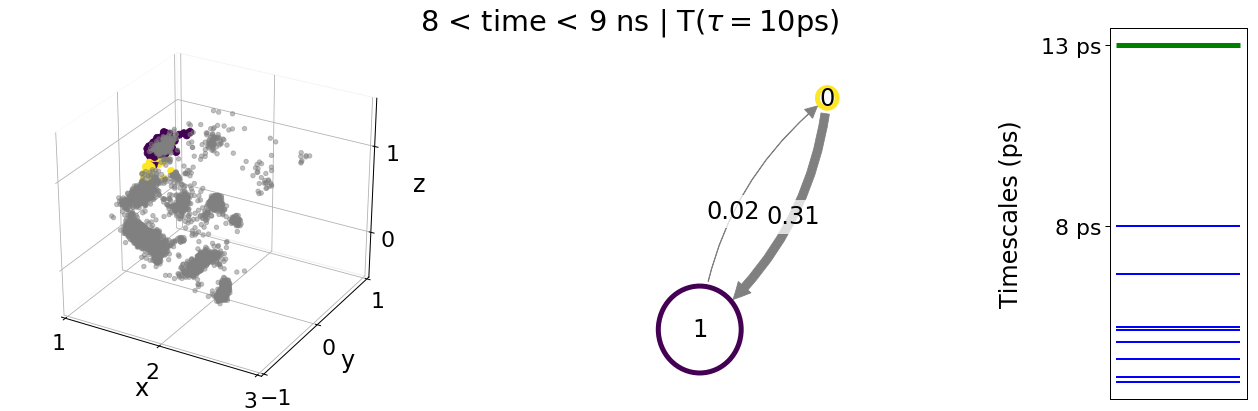

In [250]:
def axis_labs(ax):
    ax.set_xlim(1,3.); ax.set_ylim(-1, 1.); ax.set_zlim(-0.5, 1.5)
    ax.set_xlabel('x', labelpad=10); ax.set_ylabel('y', labelpad=10); ax.set_zlabel('z', labelpad=10)
    ax.xaxis.pane.fill=False; ax.yaxis.pane.fill=False; ax.zaxis.pane.fill=False
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=1))
    ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=1))
    ax.zaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=1))
    return ax

for k, v in list(hmm_dict.items())[1:2]:
    with sns.plotting_context('paper', font_scale=2.5):

        # Get the relevant data
        idx = k
        hmm = v
        
        N = hmm.nstates
        obs_to_hid = np.argmax(hmm.metastable_memberships, axis=1)
        h_traj = [obs_to_hid[i] for i in hmm.discrete_trajectories_obs[0]]
        pi =hmm.pi

        # Position data
        stride = 10
        big_stride = int(traj.shape[0]/10000)

        traj_idx = traj_split[idx]
        n_points = traj_idx[::stride,0].shape[0]

        # Set up figure and axes
        scale=1.5
        fig = plt.figure(figsize=(scale*12, scale*4))
        gs = fig.add_gridspec(1, 3,
                           width_ratios=[3,3,1])
        ax1 = fig.add_subplot(gs[0],projection='3d')
        ax2 = fig.add_subplot(gs[1])
        ax3 = fig.add_subplot(gs[2])

        fig.suptitle('{0} < time < {1} ns'.format(idx, idx+1) + r' | T($\tau={:4.0f}$ps)'.format(np.round(hmm.lag*dt, -1)), 
                     horizontalalignment='center', verticalalignment='top')

        # Set up colors    
        cmap_use = 'viridis_r'
        cmap = matplotlib.cm.get_cmap(cmap_use,N)
        cols = [cmap(n) for n in range(N)]

        # cluster centers
        ax1.scatter(xs=traj_idx[::stride,0], ys=traj_idx[::stride,1], 
                    zs=traj_idx[::stride,2], alpha=1, c=h_traj[::stride], 
                   zorder=1, s=50, cmap=cmap) 

        # Whole trajectory
        ax1.scatter(xs=traj[::big_stride,0], ys=traj[::big_stride,1],
                   zs=traj[::big_stride,2], alpha=0.5,s=20, zorder=1, color='grey')
        ax1 = axis_labs(ax1)

        # Network
        r = 0.8
        x = np.array([r * np.cos(2*np.pi*n/N + np.pi/6) for n in range(N)])
        y = np.array([r * np.sin(2*np.pi*n/N + np.pi/6) for n in range(N)])
        pos = np.concatenate((y[:,np.newaxis], x[:, np.newaxis]), axis=1)
        _, _ = plot_markov_model(hmm.transition_matrix, ax=ax2, 
                                      arrow_curvature=3, state_colors=cols,
                                      arrow_label_format = '%2.2f',pos=pos,
                                      figpadding=0.3, arrow_scale=0.5, state_scale=2)

        # Timescale plots
        mm = msms[idx]
        t_max = 10
        ts = mm.timescales()[:t_max]*dt

        # Slow:
        ax3.hlines(ts[0], 0, 1, lw=5, color='g', label='Slow')
        for i in range(1,N-1): 
            ax3.hlines(ts[i], 0, 1, lw=5, color='g')
        # Fast
        ax3.hlines(ts[N-1], 0, 1, lw=2, color='b', label='Fast')
        for i in range(N-1,t_max): ax3.hlines(ts[i], 0, 1, lw=2, color='b')
        ax3.set_yscale('log')
        ax3.set_ylabel('Timescales (ps)')
        locator = matplotlib.ticker.FixedLocator(locs=ts[:N], nbins=N)
        formatter = matplotlib.ticker.StrMethodFormatter('{x:4.0f} ps')
        ax3.yaxis.set_major_formatter(formatter)
        ax3.yaxis.set_major_locator(locator)
        ax3.tick_params(which='minor', labelleft=False, left=False)
        ax3.tick_params(which='major', labelbottom = False, bottom=False)

        plt.tight_layout()
        plt.savefig('images/traj-3-section-{}'.format(idx))
